<center><h1>Chen_Shufen_HW5</h1></center>
<br>
<br>

Name: Shufen Chen
<br>
Github Username: shufench-usc
<br>
USC ID: 9180940635

## 1. Decision Trees as Interpretable Models

Import packages

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import cross_val_score,KFold
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

### (a) Obtain Data

Get the Accute Inamations Data Set

In [150]:
# get the Accute Inflamations dataset
ai = pd.read_csv(
    "../data/Accute_Inflamations/diagnosis.data",
    sep="\t",  # Attributes are separated by TAB
    header=None,
    encoding="utf-16",  # .names says it's ASCII, but it's actually UTF-16
    engine="python",
)

# create the variable and column names mapping dictionary
col_map = {
    "T": "Temperature",
    "ON": "Nausea",
    "LP": "Lumbar pain",
    "UP": "Urine pushing",
    "MP": "Micturition pains",
    "BU": "Urethra Symptoms",
    "IUB": "Inflammation",
    "NRPO": "Nephritis",
}

# create a mapping dictionary for {yes, no} to {1,0}
num_map = {"yes": 1, "no": 0}

# rename the columns of dataframe
ai.columns = ["T", "ON", "LP", "UP", "MP", "BU", "IUB", "NRPO"]

# cnvert {yes, no} into {1,0}
ai = ai.replace(num_map)

# convert temperature from object into float
ai["T"] = ai["T"].astype(str).str.replace(",", ".").astype(float)

print(ai)

        T  ON  LP  UP  MP  BU  IUB  NRPO
0    35.5   0   1   0   0   0    0     0
1    35.9   0   0   1   1   1    1     0
2    35.9   0   1   0   0   0    0     0
3    36.0   0   0   1   1   1    1     0
4    36.0   0   1   0   0   0    0     0
..    ...  ..  ..  ..  ..  ..  ...   ...
115  41.4   0   1   1   0   1    0     1
116  41.5   0   0   0   0   0    0     0
117  41.5   1   1   0   1   0    0     1
118  41.5   0   1   1   0   1    0     1
119  41.5   0   1   1   0   1    0     1

[120 rows x 8 columns]


/var/folders/n2/qm35mwj17rxdqgtkgj7wbqmr0000gn/T/ipykernel_13126/607591019.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ai = ai.replace(num_map)


### (b) Build a decision tree

In this part, I tried two different ways to build the decision tree using label powerest method. One is using the sklearn pakage and the other is setting labels manually.

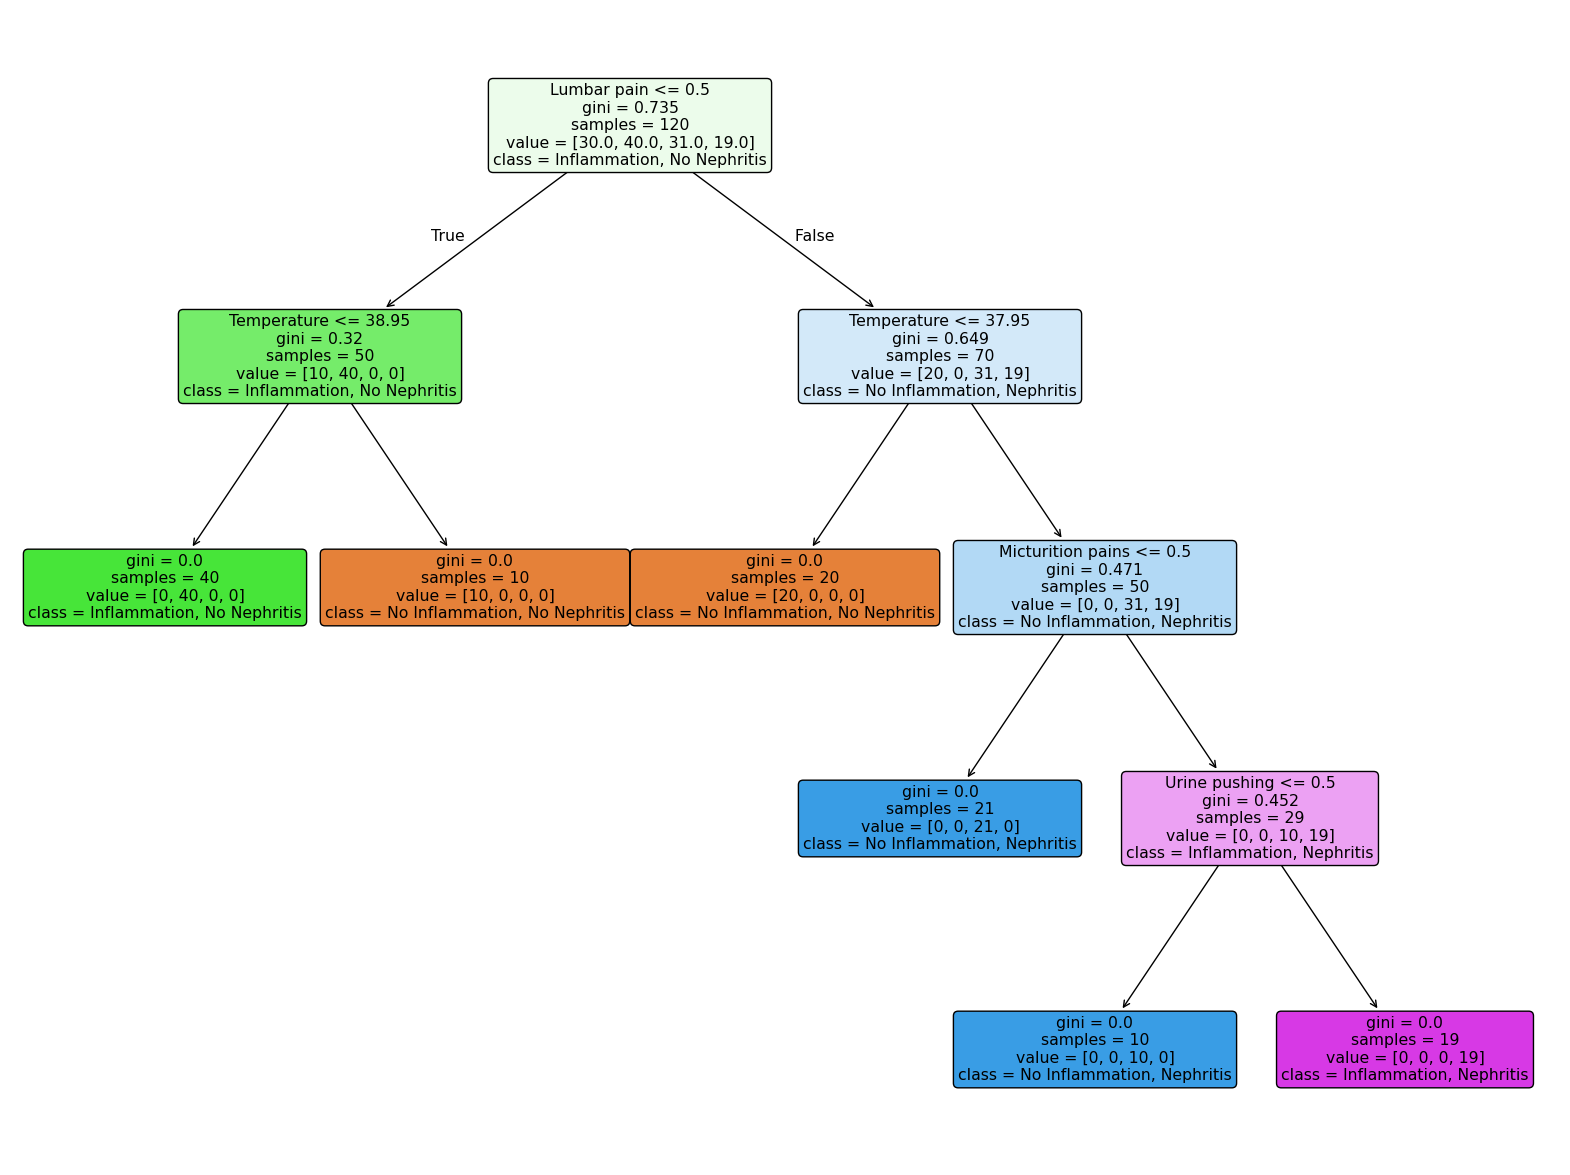

In [151]:
# get the features and labels
features = ai.iloc[:, :6]
labels = ai.drop(features.columns, axis=1)

# get the feature names
feat_names = features.columns.map(lambda c: col_map[c])


# initialize LabelPowerset multi-label classifier with a DecisionTreeClassifier
clf_lp = LabelPowerset(classifier=DecisionTreeClassifier())
clf_lp.fit(features, labels)


# get the class names from the classifier
c_id = clf_lp.classifier.classes_
c = clf_lp.inverse_transform(c_id)
dense = c.toarray()

# get the corresponding column names
y_copy = labels.copy()
y_copy.columns = y_copy.columns.map(lambda c: col_map[c])
cols = np.array(y_copy.columns)

c_names = []
for row in dense:
    parts = []
    for j in range(len(cols)):
        if row[j] == 1:
            parts.append(cols[j])
        else:
            parts.append("No " + cols[j])
    combo_str = ", ".join(parts)
    c_names.append(combo_str)

# plot the decision tree
plt.figure(figsize=(20, 15))
plot_tree(
    clf_lp.classifier,
    feature_names=feat_names,
    class_names=c_names,
    filled=True,
    rounded=True,
)
plt.show()

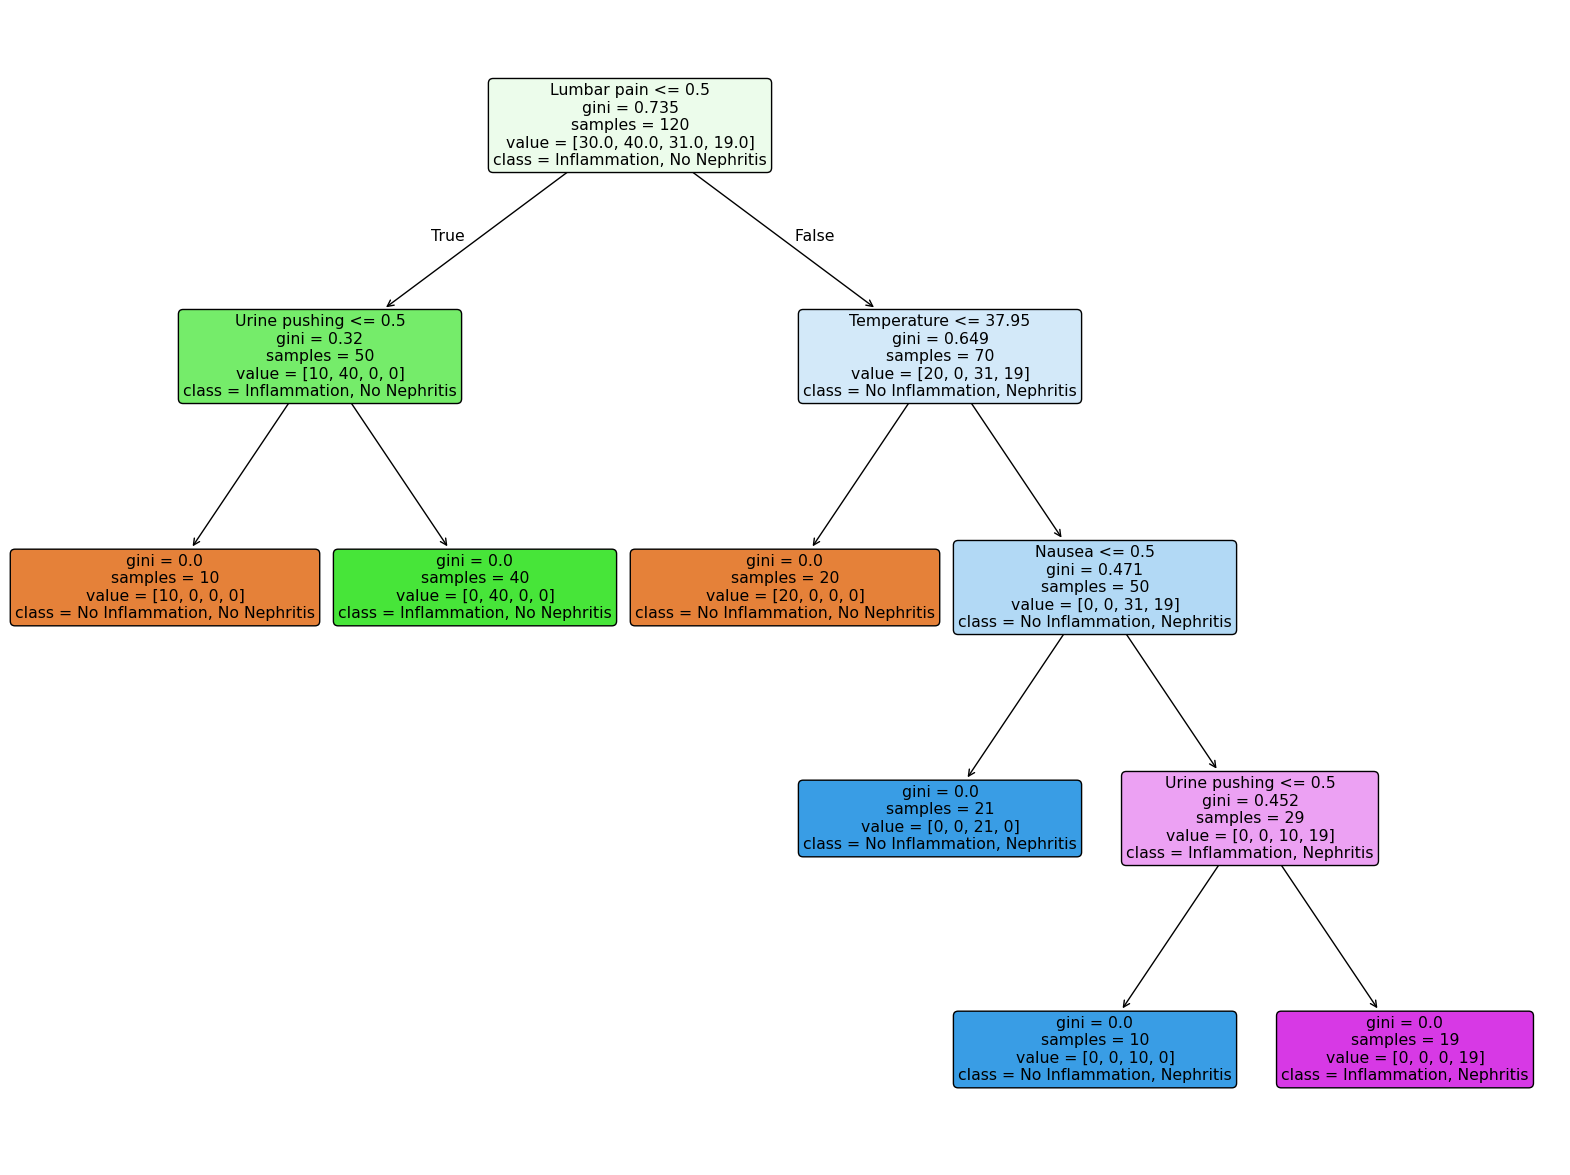

In [152]:
# applied the label powerest method munnally
ai["label"] = ai["IUB"] + 2 * ai["NRPO"]

ai_feat = ai.iloc[:, :6]
ai_label = ai.iloc[:, -1:]

# fit a decision tree classifier
clf_dt = DecisionTreeClassifier()
clf_dt.fit(ai_feat, ai_label)

# set the class names
c_names = [
    "No Inflammation, No Nephritis",
    "Inflammation, No Nephritis",
    "No Inflammation, Nephritis",
    "Inflammation, Nephritis",
]

# plot the decision tree
plt.figure(figsize=(20, 15))
plot_tree(
    clf_dt, feature_names=feat_names, class_names=c_names, filled=True, rounded=True
)
plt.show()

### (c) Convert the decision rules

In [153]:
# function to output decision tree as IF-THEN rules
def tree_to_code(tree, feature_names):
    """
    Outputs a decision tree model as a Python function

    Parameters:
    -----------
    tree: decision tree model
            The decision tree to represent as a function
    feature_names: list
            The feature names of the dataset used for building the decision tree
    """

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)


tree_to_code(clf_dt, feat_names)

def tree(Temperature, Nausea, Lumbar pain, Urine pushing, Micturition pains, Urethra Symptoms):
  if Lumbar pain <= 0.5:
    if Urine pushing <= 0.5:
      return [[1. 0. 0. 0.]]
    else:  # if Urine pushing > 0.5
      return [[0. 1. 0. 0.]]
  else:  # if Lumbar pain > 0.5
    if Temperature <= 37.95000076293945:
      return [[1. 0. 0. 0.]]
    else:  # if Temperature > 37.95000076293945
      if Nausea <= 0.5:
        return [[0. 0. 1. 0.]]
      else:  # if Nausea > 0.5
        if Urine pushing <= 0.5:
          return [[0. 0. 1. 0.]]
        else:  # if Urine pushing > 0.5
          return [[0. 0. 0. 1.]]


#### (d) cost-complexity pruning

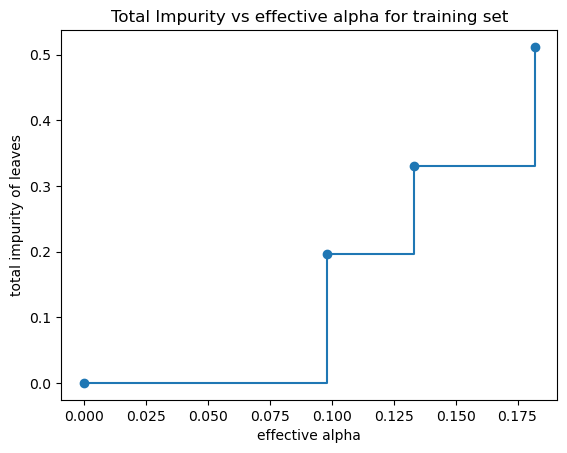

In [154]:
# get the cost complexity pruning path
path = clf_dt.cost_complexity_pruning_path(ai_feat, ai_label)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

# plot the total impurity vs effective alpha
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [155]:
# find the best alpha value for pruning the decision tree using cross-validation
alpha_res = []

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# fit decision tree with different alpha and calculate cv scores
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf, ai_feat, ai_label, cv=cv)

    # store the results in a list of dictionaries
    alpha_res.append(
        {
            "alpha": ccp_alpha,
            "mean_acc": scores.mean(),
            "std_acc": scores.std(),
        }
    )

# convert results into a pandas dataframe
alpha_df = pd.DataFrame(alpha_res)
print(alpha_df)

best_alpha = alpha_df.loc[alpha_df["mean_acc"].idxmax(), "alpha"]
print("best_alpha =", best_alpha)

      alpha  mean_acc   std_acc
0  0.000000  0.991667  0.016667
1  0.098167  0.883333  0.096465
2  0.133333  0.766667  0.097183
3  0.182000  0.658333  0.113039
4  0.222917  0.441667  0.077280
best_alpha = 0.0


As we can see, the best decision tree is the one without pruning. However, we need to find a minimal tree with high interpretability, the one will the the decision tree with the highest accuracy and a non-zero alpha.

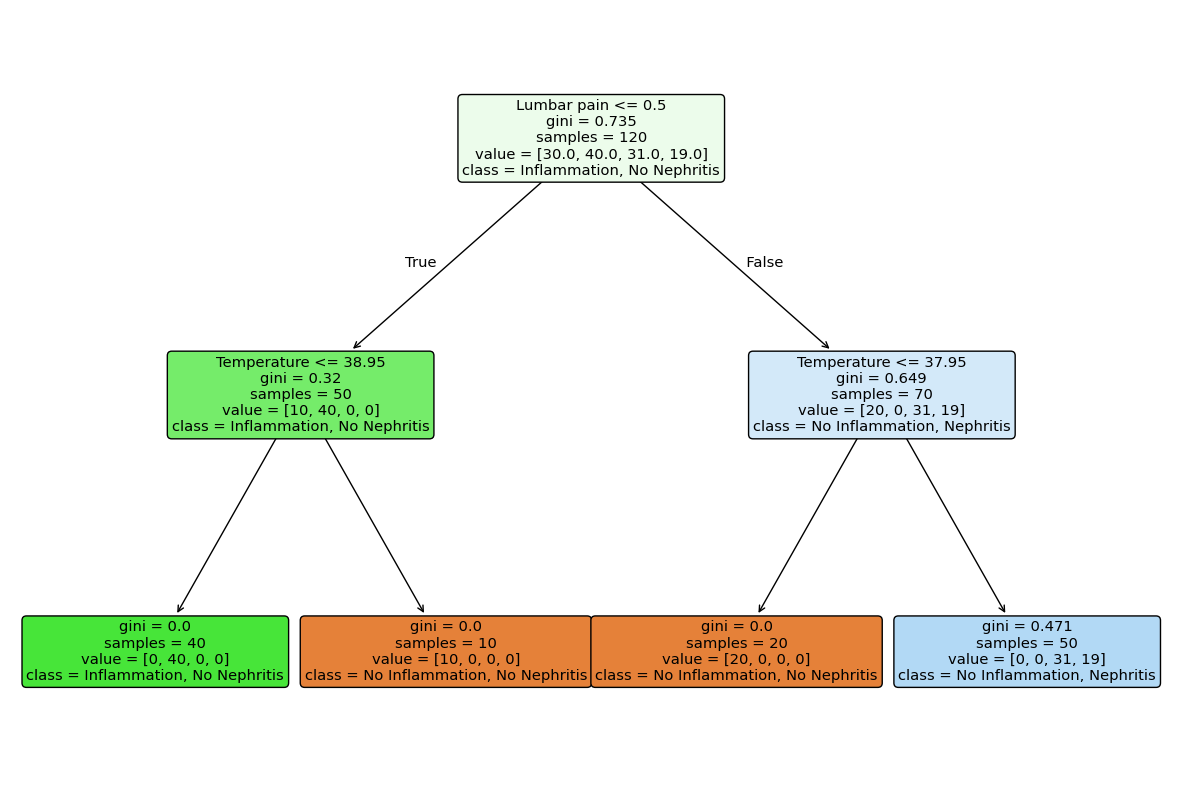

def tree(Temperature, Nausea, Lumbar pain, Urine pushing, Micturition pains, Urethra Symptoms):
  if Lumbar pain <= 0.5:
    if Temperature <= 38.95000076293945:
      return [[0. 1. 0. 0.]]
    else:  # if Temperature > 38.95000076293945
      return [[1. 0. 0. 0.]]
  else:  # if Lumbar pain > 0.5
    if Temperature <= 37.95000076293945:
      return [[1. 0. 0. 0.]]
    else:  # if Temperature > 37.95000076293945
      return [[0.   0.   0.62 0.38]]


In [156]:
final_tree = DecisionTreeClassifier(ccp_alpha=alpha_df.loc[1, "alpha"])
final_tree.fit(ai_feat, ai_label)

plt.figure(figsize=(15, 10))
plot_tree(
    final_tree, feature_names=feat_names, class_names=c_names, filled=True, rounded=True
)
plt.show()

tree_to_code(final_tree, feat_names)

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [157]:
# get the Communities and Crime dataset
df = pd.read_csv("../data/communities+and+crime /communities.data", header=None)

# get the column names from the.names file
col_ls = []
with open("../data/communities+and+crime /communities.names", "r") as f:
    for line in f:
        if line.startswith("@attribute"):
            parts = line.split(" ")
            col_ls.append(parts[1])
df.columns = col_ls

# check the dataset
print(df)

# get the first 1495 rows as training set and the rest as test set
tr_df = df.iloc[:1495, :]
te_df = df.iloc[1495:, :]

# check the shapes of the training and test sets
print(tr_df.shape)
print(te_df.shape)

      state county community        communityname  fold  population  \
0         8      ?         ?         Lakewoodcity     1        0.19   
1        53      ?         ?          Tukwilacity     1        0.00   
2        24      ?         ?         Aberdeentown     1        0.00   
3        34      5     81440  Willingborotownship     1        0.04   
4        42     95      6096    Bethlehemtownship     1        0.01   
...     ...    ...       ...                  ...   ...         ...   
1989     12      ?         ?    TempleTerracecity    10        0.01   
1990      6      ?         ?          Seasidecity    10        0.05   
1991      9      9     80070        Waterburytown    10        0.16   
1992     25     17     72600          Walthamcity    10        0.08   
1993      6      ?         ?          Ontariocity    10        0.20   

      householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0              0.33          0.02          0.90          0.12  ... 

### (b) Missing values

In [158]:
# ignore the nonpredictive variables
non_pre = ["state", "county", "community", "communityname", "fold"]
tr = tr_df.drop(columns=non_pre)
te = te_df.drop(columns=non_pre)

# convert all columns to numeric, coerce errors to NaN
tr = tr.apply(pd.to_numeric, errors="coerce")
te = te.apply(pd.to_numeric, errors="coerce")

# fill missing values with the medians of the corresponding columns of the training set
for i in tr.columns:
    median_val = tr[i].median()
    tr[i] = tr[i].fillna(median_val)
    te[i] = te[i].fillna(median_val)

### (c) Plot a correlation matrix

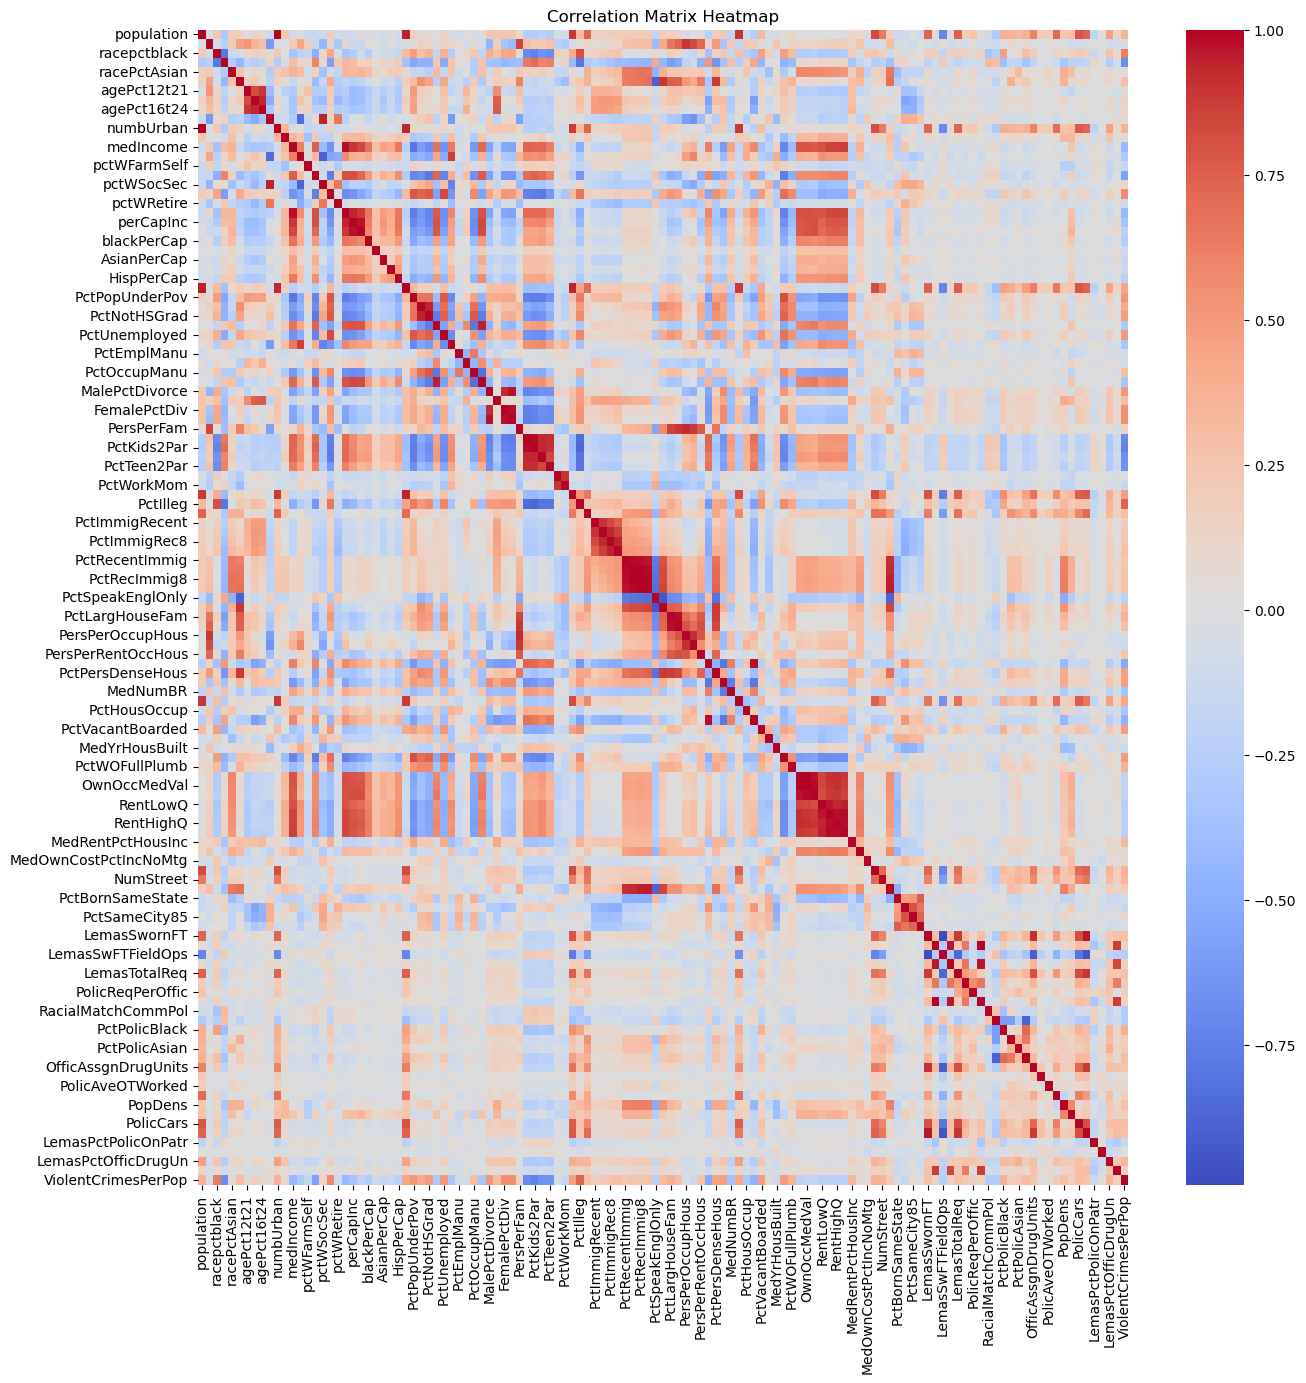

In [159]:
# combine the training and test sets for correlation analysis
comb = pd.concat([tr, te], axis=0)

# Calculate the correlation matrix
correlation_matrix = comb.corr()

# Create a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [160]:
# Calculate the coefficient of variation for each feature
stats = comb.describe()
stds = stats.loc["std"]
means = stats.loc["mean"]
cvs = stds / means

# Create a dataframe of coefficient of variation
cv_df = pd.DataFrame(cvs, columns=["CV"])

print(cv_df)

                           CV
population           2.203503
householdsize        0.353298
racepctblack         1.410920
racePctWhite         0.323782
racePctAsian         1.359162
...                       ...
LemasPctPolicOnPatr  0.117807
LemasGangUnitDeploy  0.333483
LemasPctOfficDrugUn  2.555266
PolicBudgPerPop      0.431524
ViolentCrimesPerPop  0.979015

[123 rows x 1 columns]


### (e) Scatter plots and box plots for highest CV features

                           CV
PctPolicAsian        5.447835
NumStreet            4.407702
NumInShelters        3.485481
NumIlleg             2.994196
NumImmig             2.900497
LemasPctOfficDrugUn  2.555266
NumUnderPov          2.304970
population           2.203503
LemasSwornFT         2.080712
numbUrban            2.001744
HousVacant           1.958780


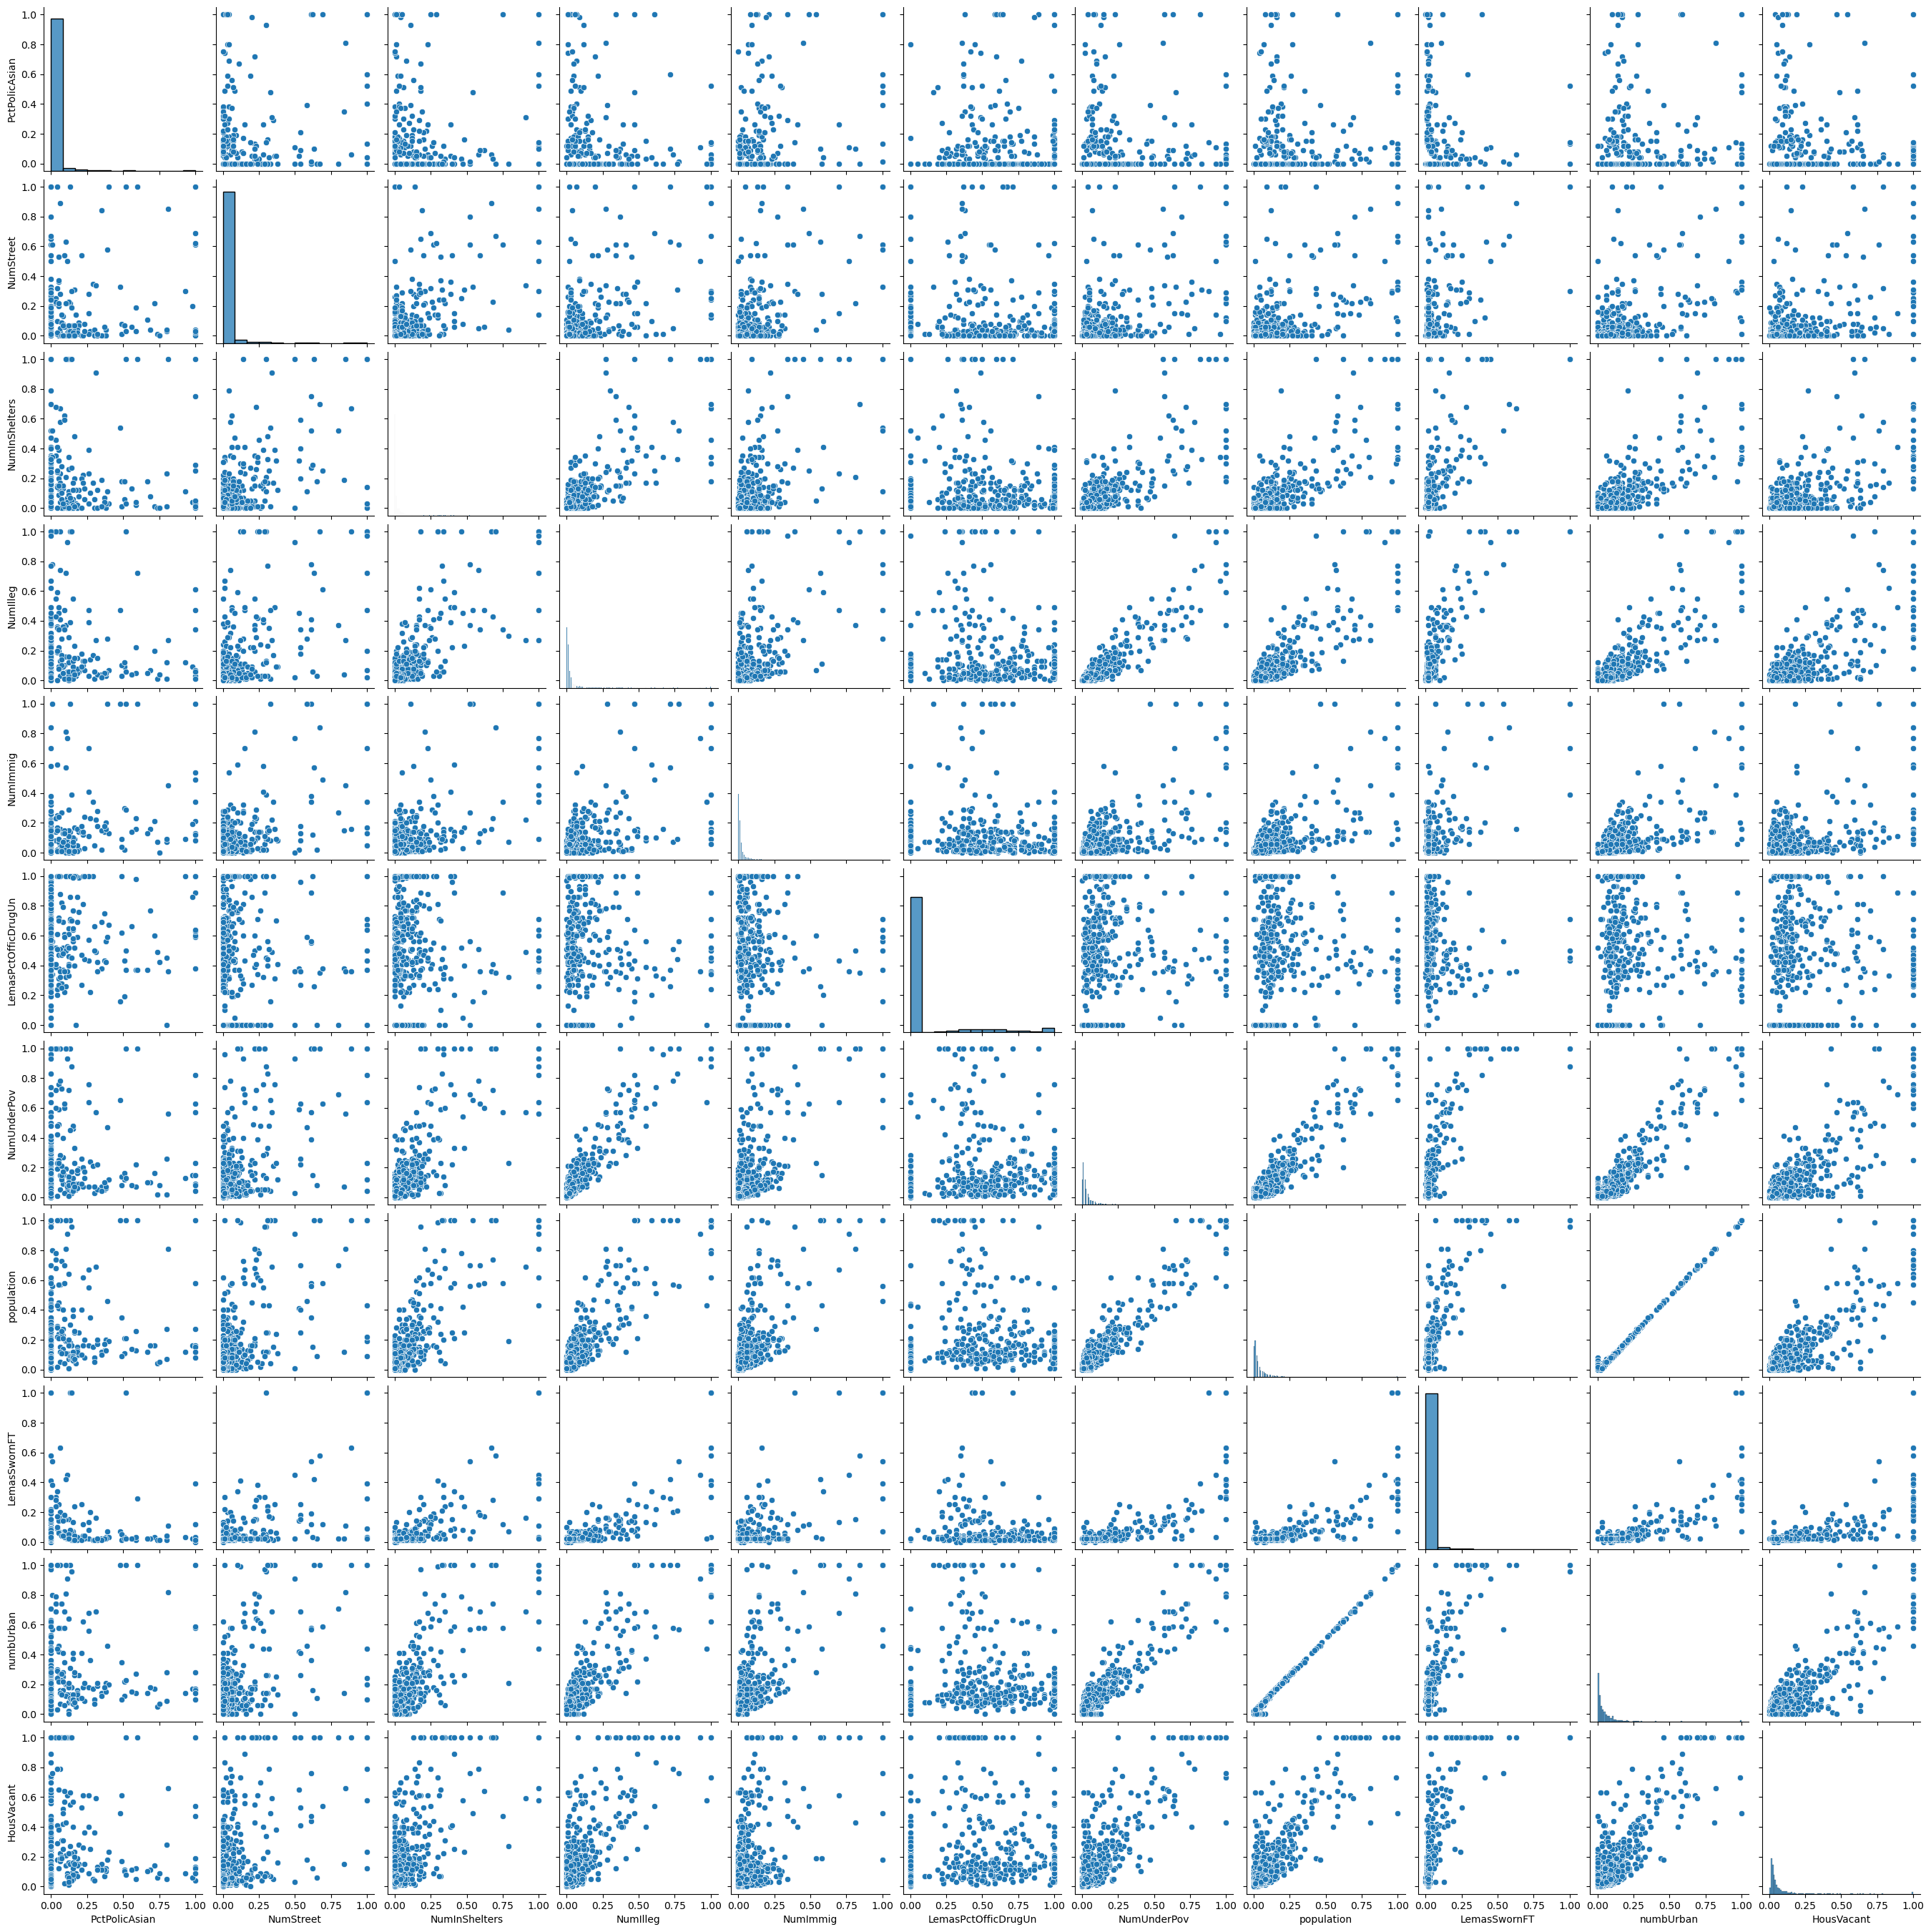

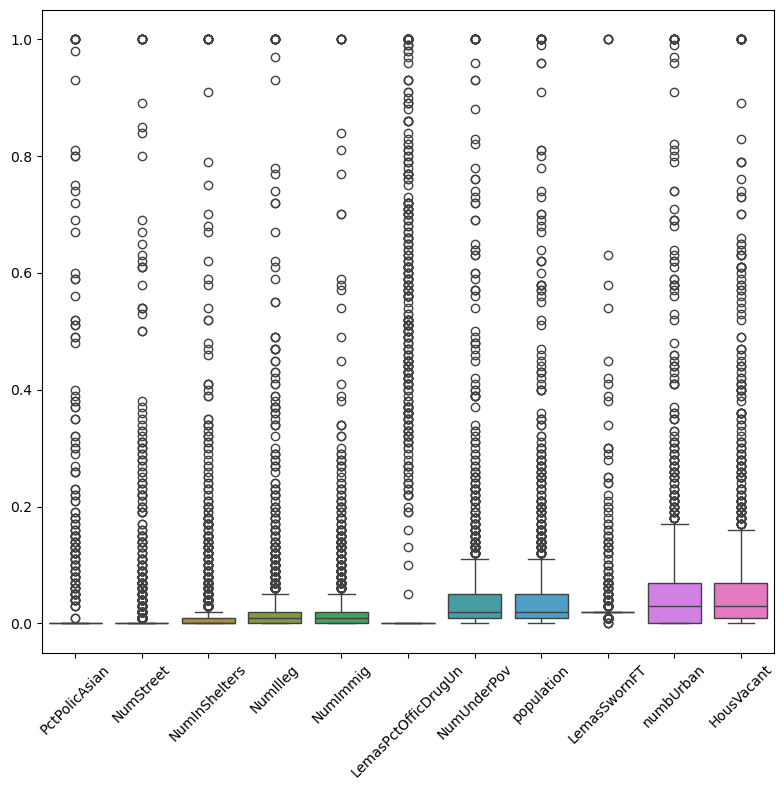

In [161]:
# Get the top sqrt(128) features with highest coefficient of variation
row_num = int(np.sqrt(128))
rows = cv_df.sort_values(by="CV", ascending=False).head(row_num)
print(rows)

# Get the rresponding column names
index_ls = rows.index.tolist()

# scatter plot
sns.pairplot(data=comb[index_ls])
plt.show()

# boxplot
plt.figure(figsize=(8, 8))
sns.boxplot(data=comb[index_ls])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### (f) Fit a linear model

In [162]:
# Get the predictors and the response variable form the training set and test set
X_train = tr.iloc[:, :-1]
y_train = tr.iloc[:, -1]

X_test = te.iloc[:, :-1]
y_test = te.iloc[:, -1]

# Fit a linear regression model using least squares
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(
    "The test mean squared error(MSE) of the linear regression model is:",
    mean_squared_error(y_test, y_pred),
)

The test mean squared error(MSE) of the linear regression model is: 0.01796621542606734


### (g) Fit a ridge regression model

In [163]:
# Set the alpha parameter range and cross-validation strategy
alp = np.logspace(-4, 4, 50)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Fit Ridge regression with cross-validation
clf_ridge = RidgeCV(alphas=alp, cv=cv)
clf_ridge.fit(X_train, y_train)

# get the best alpha
print("The best alpha of the Ridge regression is:", clf_ridge.alpha_)

# Evaluate the model on the test set
y_pred = clf_ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("The test mean squared error(MSE) of the Ridge regression model is:", mse)

The best alpha of the Ridge regression is: 3.727593720314938
The test mean squared error(MSE) of the Ridge regression model is: 0.0174609064184385


### (h) Fit a LASSO model

In [164]:
# Set the alpha parameter range and cross-validation strategy
alp = np.logspace(-4, 4, 50)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Fit Lasso regression with cross-validation without standardization
clf_lasso = LassoCV(alphas=alp, cv=cv, max_iter=10000)
clf_lasso.fit(X_train, y_train)

# get the best alpha
print("The best alpha of the unstandardized LASSO regression is:", clf_lasso.alpha_)

# Evaluate the model on the test set
y_pred = clf_lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(
    "The test mean squared error(MSE) of the unstandardized LASSO regression model is:",
    mse,
)

# Get the list of selected features
coef = clf_lasso.coef_
thr = 1e-8
selected = X_train.columns[np.abs(coef) > thr].tolist()
print("The list of selected features:", selected)
print("Numbers of selected features", len(selected))

The best alpha of the unstandardized LASSO regression is: 0.0001
The test mean squared error(MSE) of the unstandardized LASSO regression model is: 0.017658676445819078
The list of selected features: ['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctBSorMore', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 

In [165]:
# Fit Lasso regression with cross-validation with standardization
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("lasso", LassoCV(alphas=alp, cv=cv, max_iter=10000)),
    ]
)
pipe.fit(X_train, y_train)

# get the best alpha
best_alpha = pipe.named_steps["lasso"].alpha_
print("The best alpha of the standardized LASSO regression is:", best_alpha)

# Evaluate the model on the test set
y_pred = pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(
    "The test mean squared error(MSE) of the standardized LASSO regression model is:",
    mse,
)

# Get the list of selected features
coef_std = pipe.named_steps["lasso"].coef_
thr = 1e-8
selected = X_train.columns[(np.abs(coef_std) > thr)].tolist()
print("The list of selected features:", selected)
print("Numbers of selected features", len(selected))

The best alpha of the standardized LASSO regression is: 0.0006551285568595509
The test mean squared error(MSE) of the standardized LASSO regression model is: 0.017715169143141203
The list of selected features: ['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 

### (i) Fit a PCR model

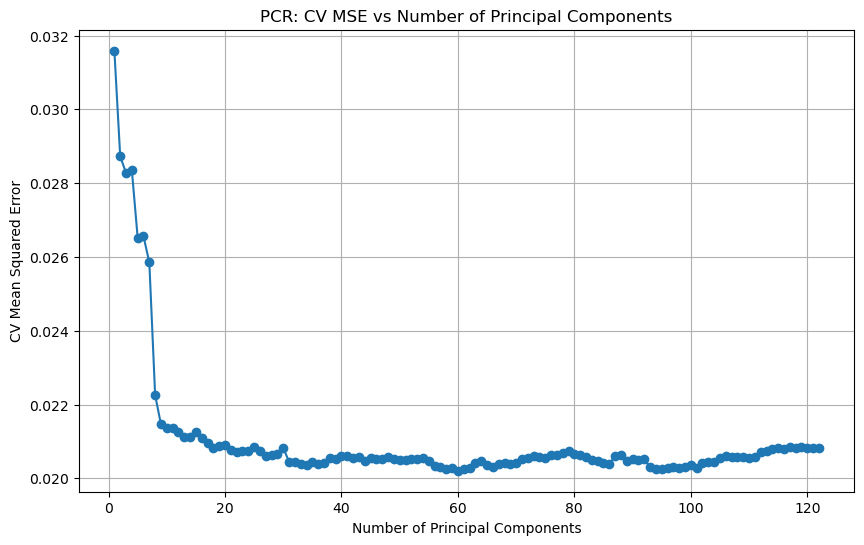

Best number of principal components: 60
The test mean squared error(MSE) with PCR is: 0.018349525286169944


In [166]:
# The maximum number of principal components is the number of features in the dataset
components = X_train.shape[1]

# Set the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# an empty list to store CV MSE for different number of principal components
tr_mses = []

# fit PCR with different number of principal components and calculate CV MSE
for comp in range(1, components + 1):
    pcr = Pipeline(
        [
            ("scaler", StandardScaler()),  # standardize the data
            ("pca", PCA(n_components=comp)),  # PCA
            ("reg", LinearRegression()),
        ]
    )

    # calculate CV MSE
    scores = cross_val_score(
        pcr, X_train, y_train, cv=cv, scoring="neg_mean_squared_error"
    )
    tr_mses.append(-scores.mean())

# plot the CV MSE vs number of principal components
plt.figure(figsize=(10, 6))
plt.plot(range(1, components + 1), tr_mses, marker="o")
plt.xlabel("Number of Principal Components")
plt.ylabel("CV Mean Squared Error")
plt.title("PCR: CV MSE vs Number of Principal Components")
plt.grid()
plt.show()

# convert the results into a dataframe
pcr_df = pd.DataFrame(
    {"Number of Components": range(1, components + 1), "CV_MSE": tr_mses}
)

# find the best number of principal components by CV MSE
b_pc = pcr_df.loc[pcr_df["CV_MSE"].idxmin(), "Number of Components"]
print("Best number of principal components:", b_pc)

# fit PCR with the best number of principal components and calculate test MSE
pcr_final = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=b_pc)),
        ("reg", LinearRegression()),
    ]
)
pcr_final.fit(X_train, y_train)

# calculate test MSE
y_pred = pcr_final.predict(X_test)
te_mse = mean_squared_error(y_test, y_pred)
print("The test mean squared error(MSE) with PCR is:", te_mse)

### (j) Fit a boosting tree

In [167]:
# Set the alpha parameter range and cross-validation strategy
alps = np.logspace(-3, 2, 10)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

tr_mses = []
# Fit XGBoost regression with different alpha values and calculate CV MSE
for alp in alps:
    model = XGBRegressor(reg_alpha=alp, objective="reg:squarederror")
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_mean_squared_error",
    )
    tr_mses.append(-scores.mean())

best_alpha = alps[np.argmin(tr_mses)]
print(
    f"The best alpha of the l1 penalty gradient boosting tree is: {best_alpha}, with CV MSE: {min(tr_mses)}"
)

# Fit the final XGBoost model with the best alpha and evaluate on the test set
xgb_final = XGBRegressor(reg_alpha=best_alpha, objective="reg:squarederror")
xgb_final.fit(X_train, y_train)
y_pred = xgb_final.predict(X_test)

# Evaluate the test MSE with the best alpha
te_mse = mean_squared_error(y_test, y_pred)
print(
    f"The test mean squared error(MSE) with the l1 penalty gradient boosting tree is: {te_mse}"
)

The best alpha of the l1 penalty gradient boosting tree is: 2.1544346900318843, with CV MSE: 0.02138920546625806
The test mean squared error(MSE) with the l1 penalty gradient boosting tree is: 0.018664896166188168


### Reference
1. Label Powerset: http://scikit.ml/api/skmultilearn.problem_transform.lp.html
2. Decision Tree Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
3. Label Powerset inverse transform: http://scikit.ml/_modules/skmultilearn/problem_transform/lp.html#LabelPowerset.inverse_transform
4. Sparse matrix: https://docs.scipy.org/doc/scipy/reference/sparse.html#module-scipy.sparse
5. IF-THEN rules: https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html
6. Cost complexity pruning: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
7. Ridge regression CV: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
8. Lasso regression CV: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
9. XGBoost: https://xgboost.readthedocs.io/en/latest/python/python_api.html?utm_source=chatgpt.com#module-xgboost.sklearn